# Experiment to find the best-performing configuration for the VAE.

The configuration will be found using the MNIST dataset

In [1]:
# First we import the model and create all the utils

from typing import Union, Callable, List, Optional
from attr import dataclass
from project.infrastructure.images.VAE import VAE
from utils.batches.application.batch_selector import BatchSelector
from utils.epsilons.application.epsilon_generator_selector import EpsilonGeneratorSelector
from utils.external.fid.fid import frechet_inception_distance
from utils.external.tvd.tvd import total_variation_distance
from utils.losses.images.application.image_loss_function_selector import ImageLossFunctionSelector
import tensorflow as tf
import numpy as np


@dataclass(frozen=True)
class ExperimetModel:
    model: VAE
    encoder_architecture: List[int]
    decoder_architecture: List[int]
    encoder_output_activation: Union[str, Callable, None]
    decoder_output_activation: Union[str, Callable, None]
    loss:str
    learning_rate: float
    n_distributions: int
    fid: Optional[float] = None
    tvd: Optional[float] = None
    fids: Optional[List[float]] = None
    tvds: Optional[List[float]] = None

POSSIBLE_LAYERS = []
for i in range(17):
    POSSIBLE_LAYERS.append(
        (list(range(25,501-25*i,25))[::-1],list(range(25,501-25*i,25)))
    )

(TRAIN_IMAGES, TRAIN_LABELS), (TEST_IMAGES, TEST_LABELS) = tf.keras.datasets.mnist.load_data()
HEIGHT = 28
WIDTH = 28
CHANNELS = 1

def create_inception_mnist_model():
    tmp_model = tf.keras.Sequential()

    # First Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    tmp_model.add(tf.keras.layers.Flatten())

    # Fully connected layers
    tmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
    tmp_model.add(tf.keras.layers.Dropout(0.5))
    tmp_model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return tmp_model

# Preprocess MNIST dataset
x_train = TRAIN_IMAGES.reshape((-1, 28,28,1))
x_test = TEST_IMAGES.reshape((-1, 28,28,1))
x_train = tf.cast(x_train, dtype=tf.float32) / 255.0
x_test = tf.cast(x_test, dtype=tf.float32) / 255.0
y_train = tf.keras.utils.to_categorical(TRAIN_LABELS, num_classes=10)
y_test = tf.keras.utils.to_categorical(TEST_LABELS, num_classes=10)

model = create_inception_mnist_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

def get_classification(x: tf.Tensor) -> tf.Tensor:
    raw_clasification = model.predict(x)
    classif = []

    for raw in raw_clasification:
        tmp = tf.where(raw == tf.reduce_max(raw), 1.0, 0.0).tolist()
        try:
            classif.append(tmp.index(1))
        except ValueError:
            max = 0
            max_cls = 0
            for cls in range(len(raw)):
                if max < raw[cls]:
                    max = raw[cls]
                    max_cls = cls
            classif.append(max_cls)

    return tf.convert_to_tensor(classif)

INTERCEPTED_LAYER_INDEX = 5

intercepted_model = tf.keras.Model(inputs=model.input, outputs=model.layers[INTERCEPTED_LAYER_INDEX].output)

def get_activations(x : tf.Tensor) -> tf.Tensor:
    return tf.convert_to_tensor(intercepted_model.predict(x))


Epoch 1/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.3250 - accuracy: 0.9003 - val_loss: 0.0628 - val_accuracy: 0.9803
Epoch 2/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1257 - accuracy: 0.9626 - val_loss: 0.0477 - val_accuracy: 0.9842
Epoch 3/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0954 - accuracy: 0.9712 - val_loss: 0.0335 - val_accuracy: 0.9878
Epoch 4/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0796 - accuracy: 0.9771 - val_loss: 0.0336 - val_accuracy: 0.9886
Epoch 5/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0697 - accuracy: 0.9793 - val_loss: 0.0296 - val_accuracy: 0.9902
Epoch 6/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0582 - accuracy: 0.9827 - val_loss: 0.0325 - val_accuracy: 0.9892
Epoch 7/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0557 - accuracy: 0.9833 - val_loss: 0.0271 -

In [2]:
# Now we will execute the experiments

TRAINING_ITERATIONS = 5000
dataset_activations = get_activations(x_test)
dataset_labels = tf.convert_to_tensor(TEST_LABELS)

print("-------------------------------------------------")
print("      Searching for the best configuration       ")
print("-------------------------------------------------")

experiments = []

for encoder_architecture,decoder_architecture in POSSIBLE_LAYERS:
    current_model = VAE(
        encoder_architecture=encoder_architecture,
        decoder_architecture=decoder_architecture,
        encoder_activations=[tf.nn.relu for _ in encoder_architecture],
        decoder_activations=[tf.nn.relu for _ in decoder_architecture],
        encoder_output_activation=tf.nn.relu,
        decoder_output_activation=tf.nn.sigmoid,
        dataset=TRAIN_IMAGES,
        loss = ImageLossFunctionSelector.ImageLosses.Dkl_MSE.value,
        learning_rate=0.0001,
        n_distributions=5,
        max_iter=TRAINING_ITERATIONS,
        image_height=28,
        image_width=28,
        n_channels=1,
    )

    current_model.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = current_model.generate_with_random_sample(x_test.shape[0])

    generated_activations = get_activations(generated_images)

    try:
        total_variation_distance_metric = total_variation_distance(
            dataset_labels, # Similar distribution and 6 times smaller
            get_classification(
                current_model.generate_with_random_sample(
                    TEST_LABELS.shape[0]
                )
            ),
            [0,1,2,3,4,5,6,7,8,9]
        )
    except Exception:
        total_variation_distance_metric = np.inf

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    print(f"FID ==================> {frechet_inception_distance_metric}")
    print(f"TVD ==================> {total_variation_distance_metric}")
    print("-------------------------------------------------")

    experiments.append(
        ExperimetModel(
            model=current_model,
            encoder_architecture=encoder_architecture,
            decoder_architecture=decoder_architecture,
            encoder_output_activation=tf.nn.relu,
            decoder_output_activation=tf.nn.sigmoid,
            loss=ImageLossFunctionSelector.ImageLosses.Dkl_MSE.value,
            learning_rate=0.0001,
            n_distributions=5,
            fid=frechet_inception_distance_metric,
            tvd=total_variation_distance_metric,
        )
    )

313/313 [==============================] - 2s 4ms/step
-------------------------------------------------
      Searching for the best configuration       
-------------------------------------------------
313/313 [==============================] - 2s 5ms/step
FID ==================> 246.04113607985838
TVD ==================> 0.10740000000000001
-------------------------------------------------
313/313 [==============================] - 2s 6ms/step
FID ==================> 261.54229994107254
TVD ==================> 0.2651
-------------------------------------------------
313/313 [==============================] - 2s 6ms/step
FID ==================> 243.9634467724599
TVD ==================> 0.1916
-------------------------------------------------
313/313 [==============================] - 1s 3ms/step
FID ==================> 235.74958349004166
TVD ==================> 0.15800000000000003
-------------------------------------------------
313/313 [==============================] - 1s 4ms/step

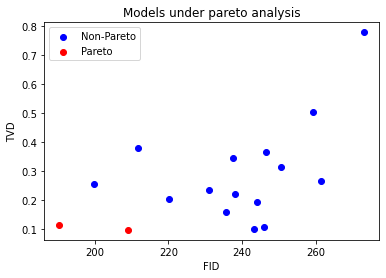

In [3]:
# Now we will analyze the experiments and see the results

#Firstly we will perform a pareto analysis over the FID and TVD metrics

pareto_set = []
non_pareto_set = []
sorted_data = sorted(experiments, key=lambda m: (m.fid, m.tvd))

# Initialize the minimum y value found so far
min_tvd = float('inf')

# Iterate over the sorted data
for m in sorted_data:
    # Check if the current point dominates the previously found points
    if m.tvd < min_tvd:
        pareto_set.append(m)
        min_tvd = m.tvd
    else:
        non_pareto_set.append(m)

#Now we will plot the models that are not dominated by one metric
import matplotlib.pyplot as plt

# Separate the points into Pareto set and non-Pareto set
pareto_x = [m.fid for m in pareto_set]
pareto_y = [m.tvd for m in pareto_set]

non_pareto_x = [m.fid for m in non_pareto_set]
non_pareto_y = [m.tvd for m in non_pareto_set]

plt.figure()
plt.scatter(non_pareto_x, non_pareto_y, color='blue', label='Non-Pareto')
plt.scatter(pareto_x, pareto_y, color='red', label='Pareto')
plt.title('Models under pareto analysis')
plt.xlabel('FID')
plt.ylabel('TVD')
plt.legend()

# Display the plot
plt.show()

Now that the pareto analysis has been performed, we will explore the consistency of both of the metrics during the training process to decide if one of the pareto models stands out

313/313 [==============================] - 4s 13ms/step
FID ==================> 297.7547173300685
TVD ==================> 0.3103


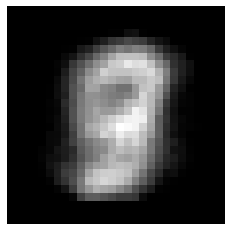

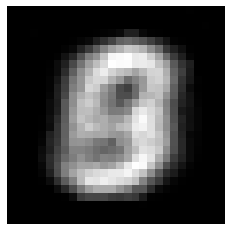

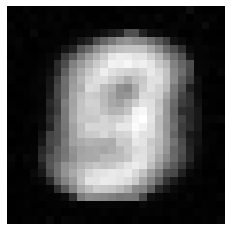

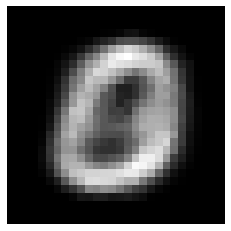

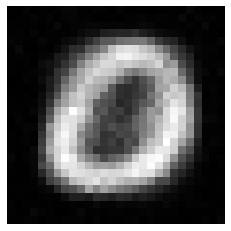

-------------------------------------------------
313/313 [==============================] - 4s 13ms/step
FID ==================> 228.40817204732485
TVD ==================> 0.1178


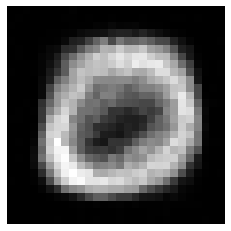

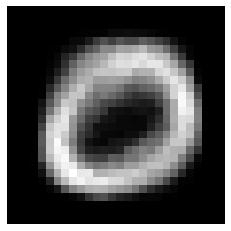

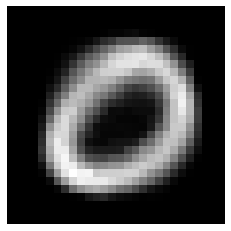

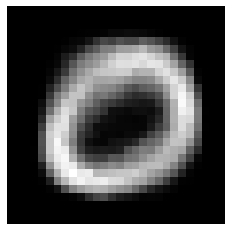

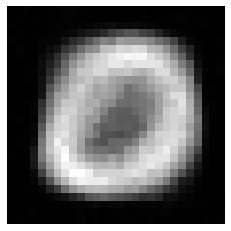

-------------------------------------------------
313/313 [==============================] - 4s 12ms/step
FID ==================> 190.99597369568173
TVD ==================> 0.0974


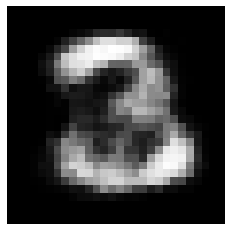

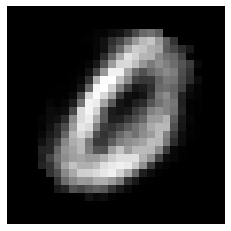

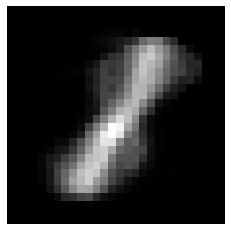

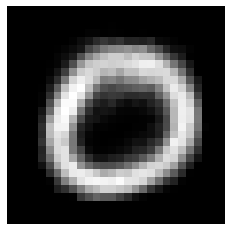

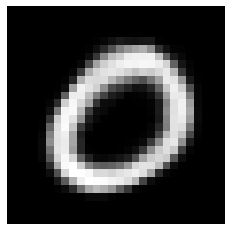

-------------------------------------------------
313/313 [==============================] - 3s 11ms/step
FID ==================> 176.63682904324315
TVD ==================> 0.0959


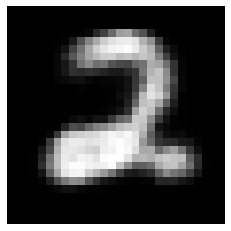

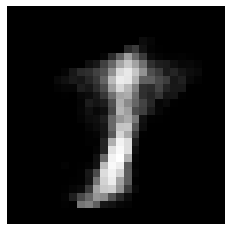

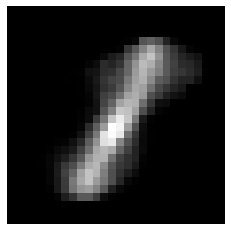

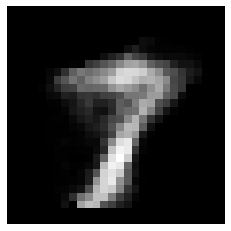

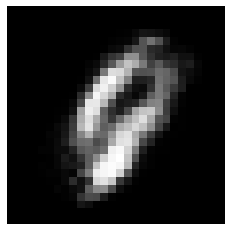

-------------------------------------------------
313/313 [==============================] - 5s 15ms/step
FID ==================> 165.36565272368486
TVD ==================> 0.094


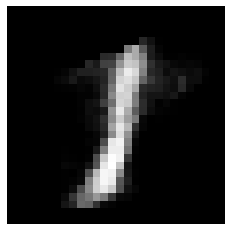

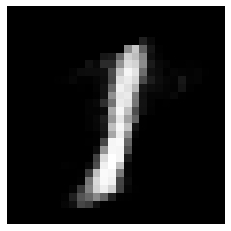

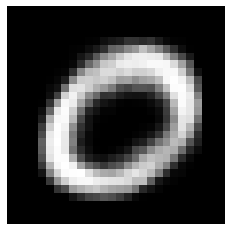

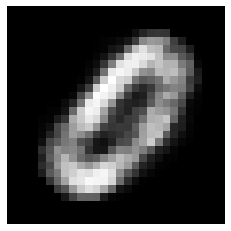

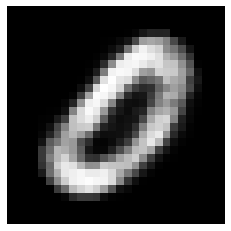

-------------------------------------------------
313/313 [==============================] - 4s 12ms/step
FID ==================> 289.6679464337421
TVD ==================> 0.2666


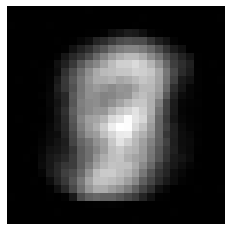

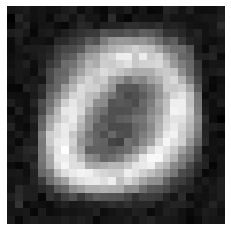

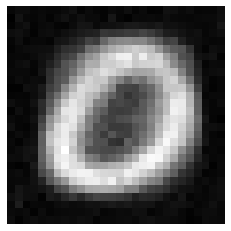

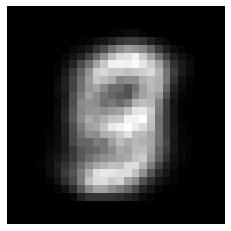

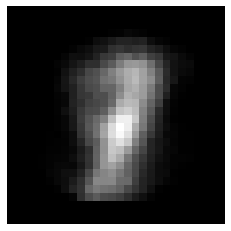

-------------------------------------------------
313/313 [==============================] - 4s 12ms/step
FID ==================> 252.11978073337795
TVD ==================> 0.1774


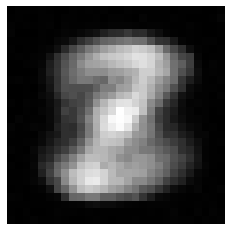

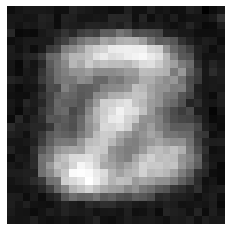

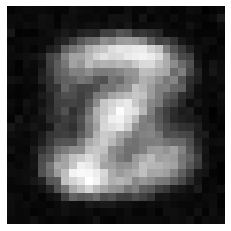

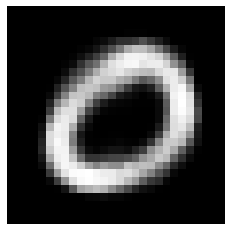

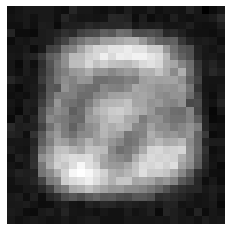

-------------------------------------------------
313/313 [==============================] - 4s 12ms/step
FID ==================> 217.15730274542227
TVD ==================> 0.12319999999999999


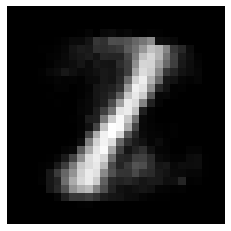

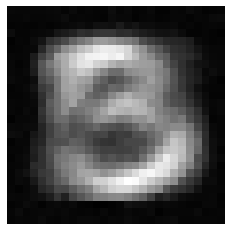

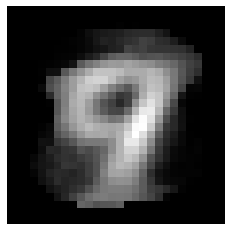

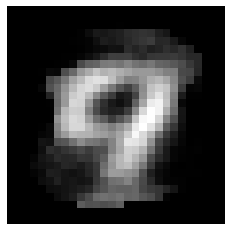

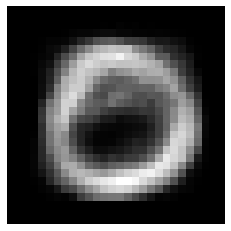

-------------------------------------------------
313/313 [==============================] - 4s 12ms/step
FID ==================> 199.80098338219491
TVD ==================> 0.09729999999999998


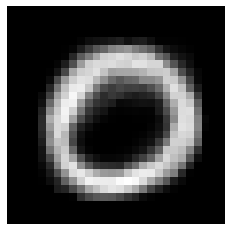

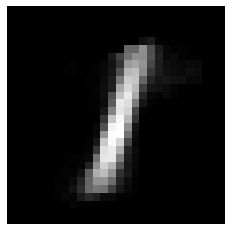

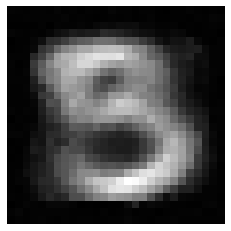

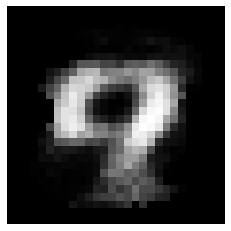

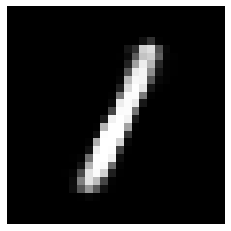

-------------------------------------------------
313/313 [==============================] - 4s 11ms/step
FID ==================> 188.27651479012033
TVD ==================> 0.1035


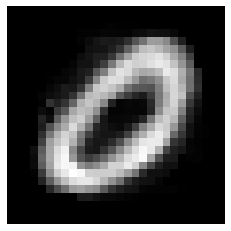

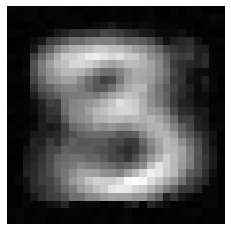

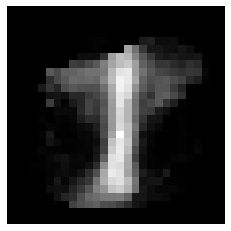

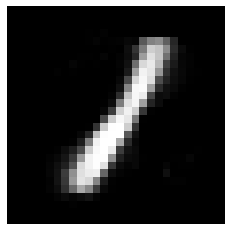

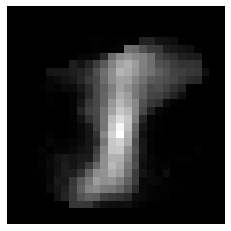

-------------------------------------------------


In [5]:
ITERATIONS = 1000
N_TRAININGS = 5
post_experiments = []

for pareto_model in pareto_set:
    current_model = VAE(
        encoder_architecture=pareto_model.encoder_architecture,
        decoder_architecture=pareto_model.decoder_architecture,
        encoder_activations=[tf.nn.relu for _ in pareto_model.encoder_architecture],
        decoder_activations=[tf.nn.relu for _ in pareto_model.decoder_architecture],
        encoder_output_activation=tf.nn.relu,
        decoder_output_activation=tf.nn.sigmoid,
        dataset=TRAIN_IMAGES,
        loss = ImageLossFunctionSelector.ImageLosses.Dkl_MSE.value,
        learning_rate=0.0001,
        n_distributions=5,
        max_iter=ITERATIONS,
        image_height=28,
        image_width=28,
        n_channels=1,
    )

    fids = []
    tvds = []
    for i in range(1, N_TRAININGS+1):
        current_model.fit_dataset(
            return_loss=True,
            epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
            batch_size=64,
            batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
            generate_samples=False,
        )

        # we select random images from the dataset
        generated_images = current_model.generate_with_random_sample(x_test.shape[0])

        generated_activations = get_activations(generated_images)

        try:
            total_variation_distance_metric = total_variation_distance(
                dataset_labels, # Similar distribution and 6 times smaller
                get_classification(
                    current_model.generate_with_random_sample(
                        TEST_LABELS.shape[0]
                    )
                ),
                [0,1,2,3,4,5,6,7,8,9]
            )
        except Exception:
            total_variation_distance_metric = np.inf

        try:
            frechet_inception_distance_metric = frechet_inception_distance(
                dataset_activations,
                generated_activations
            )
        except Exception:
            frechet_inception_distance_metric = np.inf

        fids.append(frechet_inception_distance_metric)
        tvds.append(total_variation_distance_metric)

        print(f"FID ==================> {frechet_inception_distance_metric}")
        print(f"TVD ==================> {total_variation_distance_metric}")
        current_model.generate_random_images(5,save=False)
        print("-------------------------------------------------")

    post_experiments.append(
        ExperimetModel(
            model = current_model,
            encoder_architecture = pareto_model.encoder_architecture,
            decoder_architecture = pareto_model.decoder_architecture,
            encoder_output_activation=tf.nn.relu,
            decoder_output_activation=tf.nn.sigmoid,
            loss=ImageLossFunctionSelector.ImageLosses.Dkl_MSE.value,
            learning_rate=0.0001,
            n_distributions=5,
            tvds=tvds,
            fids=fids
        )
    )

<Figure size 432x288 with 0 Axes>

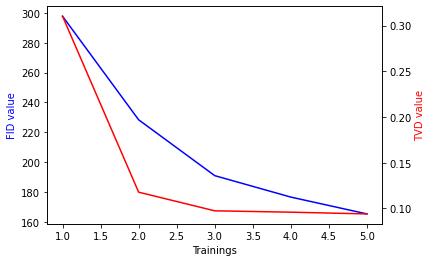

<Figure size 432x288 with 0 Axes>

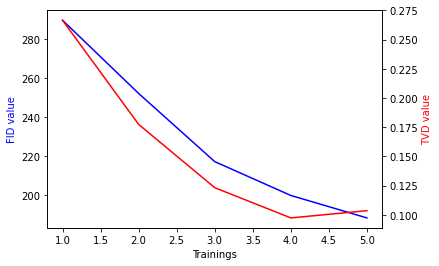

In [29]:
# Now we will see the evolution of the metrics during the training of the pareto models and evaluate if they are consistent

for m in post_experiments:
    plt.figure()
    x = [1, 2, 3, 4, 5]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x, m.fids, color='blue')
    ax2.plot(x, m.tvds, color='red')

    ax1.set_xlabel('Trainings')
    ax1.set_ylabel('FID value', color='blue')
    ax2.set_ylabel('TVD value', color='red')

    # Display the plot
    plt.show()


As we can see, the FID is sligthly more consistent than the TVD over the training epochs. So we will train again the pareto models with more iterations and we will declare as the best the one with the lowest FID

In [7]:
ITERATIONS = 25000

final_experiment = []

for pareto_model in pareto_set:
    current_model = VAE(
        encoder_architecture=pareto_model.encoder_architecture,
        decoder_architecture=pareto_model.decoder_architecture,
        encoder_activations=[tf.nn.relu for _ in pareto_model.encoder_architecture],
        decoder_activations=[tf.nn.relu for _ in pareto_model.decoder_architecture],
        encoder_output_activation=tf.nn.relu,
        decoder_output_activation=tf.nn.sigmoid,
        dataset=TRAIN_IMAGES,
        loss = ImageLossFunctionSelector.ImageLosses.Dkl_MSE.value,
        learning_rate=0.0001,
        n_distributions=5,
        max_iter=ITERATIONS,
        image_height=28,
        image_width=28,
        n_channels=1,
    )
    current_model.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = current_model.generate_with_random_sample(x_test.shape[0])

    generated_activations = get_activations(generated_images)

    try:
        total_variation_distance_metric = total_variation_distance(
            dataset_labels, # Similar distribution and 6 times smaller
            get_classification(
                current_model.generate_with_random_sample(
                    TEST_LABELS.shape[0]
                )
            ),
            [0,1,2,3,4,5,6,7,8,9]
        )
    except Exception:
        total_variation_distance_metric = np.inf

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    print(f"FID ==================> {frechet_inception_distance_metric}")
    print("-------------------------------------------------")

    final_experiment.append(
        ExperimetModel(
            model = current_model,
            encoder_architecture = pareto_model.encoder_architecture,
            decoder_architecture = pareto_model.decoder_architecture,
            encoder_output_activation=tf.nn.relu,
            decoder_output_activation=tf.nn.sigmoid,
            loss=ImageLossFunctionSelector.ImageLosses.Dkl_MSE.value,
            learning_rate=0.0001,
            n_distributions=5,
            fid=frechet_inception_distance_metric
        )
    )

313/313 [==============================] - 3s 10ms/step
FID ==================> 221.1708555830963
-------------------------------------------------
313/313 [==============================] - 4s 11ms/step
FID ==================> 189.46956874677235
-------------------------------------------------


ACCORDING TO THE EXPERIMENT, THE BEST PERFORMING CVAE MODEL IS:

ENCODER:
    Architecture =======> [175, 150, 125, 100, 75, 50, 25]
DECODER:
    Architecture =======> [25, 50, 75, 100, 125, 150, 175]
EXAMPLE OF GENERATION:



<Figure size 432x288 with 0 Axes>

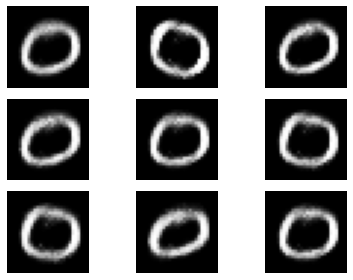

<Figure size 432x288 with 0 Axes>

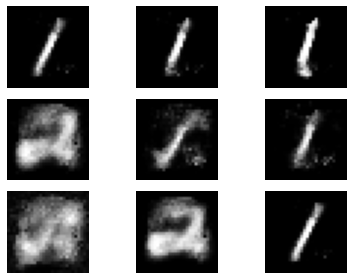

<Figure size 432x288 with 0 Axes>

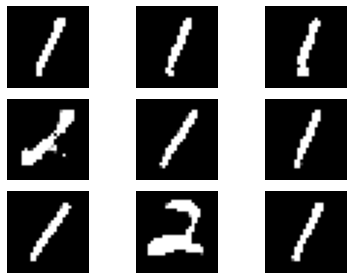

In [31]:
best = min(final_experiment, key=lambda m: m.fid)

print("ACCORDING TO THE EXPERIMENT, THE BEST PERFORMING CVAE MODEL IS:\n")
print("ENCODER:")
print(f"    Architecture =======> {best.encoder_architecture}")
print("DECODER:")
print(f"    Architecture =======> {best.decoder_architecture}")

best_generated_1=best.model.generate_with_multiple_samples(
    tf.convert_to_tensor(
        [
            [0.4,2.0,1.4,-0.2,1.0],[2.0,-0.2,2.0,-0.2,2.0],[1.4,2.0,0.4,-0.2,1.0],
            [0.4,1.4,0.4,1.4,0.4],[1.0,1.0,1.0,1.0,1.0],[1.4,0.4,1.4,0.4,1.4],
            [0.4,-0.2,1.4,2.0,1.0],[-0.2,2.0,-0.2,2.0,-0.2],[1.4,-0.2,0.4,2.0,1.0],
        ]
    )
)
best_generated_2=best.model.generate_with_multiple_samples(
    tf.convert_to_tensor(
        [
            [-0.4,0.2,-1.4,-2.0,-1.0],[-2.0,0.2,-2.0,-0.2,-2.0],[-1.4,2.0,-0.4,-0.2,-1.0],
            [-0.4,-1.4,-0.4,-1.4,-0.4],[-1.0,-1.0,-1.0,-1.0,-1.0],[-1.4,-0.4,-1.4,-0.4,-1.4],
            [-0.4,-2.0,-1.4,-0.2,-1.0],[0.2,-2.0,-0.2,-2.0,0.2],[-1.4,0.2,-0.4,-2.0,-1.0],
        ]
    )
)

best_generated_times100=best.model.generate_with_multiple_samples(
    tf.convert_to_tensor(
        [
            [-0.4,0.2,-1.4,-2.0,-1.0],[-2.0,0.2,-2.0,-0.2,-2.0],[-1.4,2.0,-0.4,-0.2,-1.0],
            [-0.4,-1.4,-0.4,-1.4,-0.4],[-1.0,-1.0,-1.0,-1.0,-1.0],[-1.4,-0.4,-1.4,-0.4,-1.4],
            [-0.4,-2.0,-1.4,-0.2,-1.0],[0.2,-2.0,-0.2,-2.0,0.2],[-1.4,0.2,-0.4,-2.0,-1.0],
        ]
    )*100
)

#Now we generate a 3x3 image
print("EXAMPLE OF GENERATION:\n")
plt.figure()
fig, axes = plt.subplots(3, 3)
for i, ax in enumerate(axes.flat):
    image = best_generated_1[i]

    ax.imshow(image, cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()

plt.figure()
fig, axes = plt.subplots(3, 3)
for i, ax in enumerate(axes.flat):
    image = best_generated_2[i]

    ax.imshow(image, cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()

plt.figure()
fig, axes = plt.subplots(3, 3)
for i, ax in enumerate(axes.flat):
    image = best_generated_times100[i]

    ax.imshow(image, cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()